7/11/2019

This notebook is for exploring how to compare our evaluation metric to ngram overlap metrics. The question is do ngram overlap metrics like BLEU/METEOR/ROUGE, etc. predict listener performance as well as our metrics.

The problem with applying BLEU in this domain is that we would need reference captions, which we don't have for the synthetic data we used to evaluate our other evaluation models. I'm therefore going to look for contexts that have the same (or similar to within a CIEDE distance of 5) colors in their contexts across the whole dataset with different target colors (train, dev, test) and see if is plausible to use them for evaluation.



In [1]:
# so we can access classes from parent directory
import sys
sys.path.append("..")

In [3]:
from monroe_data import MonroeData, MonroeDataEntry, Color # for loading in training data
from evaluation import delta_e_dist
import caption_featurizers # for tokenizing input to nltk bleu

In [32]:
import numpy as np
from skimage import color
from sklearn.cluster import KMeans
import nltk
import copy
import matplotlib.pyplot as plt
import pickle
import time
%matplotlib inline

In [5]:
# get data
train_data = MonroeData("../data/csv/train_corpus_monroe.csv", "../data/entries/train_entries_monroe.pkl")
dev_data = MonroeData("../data/csv/dev_corpus_monroe.csv", "../data/entries/dev_entries_monroe.pkl")
test_data = MonroeData("../data/csv/test_corpus_monroe.csv", "../data/entries/test_entries_monroe.pkl")

In [6]:
all_data = train_data.entries + dev_data.entries + test_data.entries

In [6]:
all_colors = [de.colors for de in all_data]

In [7]:
all_colors[:10]

[[hsl: [226, 81, 50], rgb [24, 73, 232], hsv [226, 89.50276243093923, 90.5],
  hsl: [283, 87, 50], rgb [176, 17, 239], hsv [283, 93.04812834224599, 93.5],
  hsl: [248, 92, 50], rgb [42, 10, 246], hsv [248, 95.83333333333333, 96.0]],
 [hsl: [249, 25, 50], rgb [106, 96, 160], hsv [249, 40.0, 62.5],
  hsl: [129, 66, 50], rgb [44, 212, 69], hsv [129, 79.51807228915662, 83.0],
  hsl: [54, 53, 50], rgb [196, 182, 60], hsv [54, 69.28104575163398, 76.5]],
 [hsl: [301, 57, 50], rgb [201, 55, 199], hsv [301, 72.61146496815287, 78.5],
  hsl: [302, 86, 50], rgb [238, 18, 231], hsv [302, 92.47311827956989, 93.0],
  hsl: [291, 59, 50], rgb [181, 52, 204], hsv [291, 74.21383647798743, 79.5]],
 [hsl: [87, 66, 50], rgb [136, 212, 44], hsv [87, 79.51807228915662, 83.0],
  hsl: [85, 21, 50], rgb [132, 155, 101], hsv [85, 34.710743801652896, 60.5],
  hsl: [299, 29, 50], rgb [164, 91, 165], hsv [299, 44.96124031007752, 64.5]],
 [hsl: [156, 84, 50], rgb [20, 236, 150], hsv [156, 91.30434782608695, 92.0],
  

In [8]:
len(all_colors)

46994

In [162]:
def calculate_color_distance(color1, color2):
    """
    Calcuates the CIEDE-2000 delta-e distance between two monroe_data.Color objects
    """
    return delta_e_dist(np.array(color1.rgb_norm), np.array(color2.rgb_norm))

def colors_equal(color1, color2, threshold = 20):
    return calculate_color_distance(color1, color2) < threshold

In [77]:
class HashableColorList:
    """Wrapper class that allows lists of colors to be hashable"""
    
    def __init__(self, color_list):
        self.color_list = color_list
        
    def rgb_to_hex(self, rgb):
        return ''.join(['{:02X}'.format(int(coord)) for coord in rgb])
        
    def __hash__(self):
        rgbs = [color.rgb for color in self.color_list]
        rgb_hexes = [self.rgb_to_hex(rgb) for rgb in rgbs]
        rgb_hexes = int(''.join(rgb_hexes), 16)
        return rgb_hexes
    
    def __eq__(self, other):
        return hash(self) == hash(other)
    
    def __repr__(self):
        return str([cl.rgb for cl in self.color_list])
    
    def __len__(self):
        return len(self.color_list)
    
    def __getitem__(self, key):
        return self.color_list[key]

In [111]:
%%time
color_edge_list = []
for i, color_list_1 in enumerate(all_colors_hashable):
    if i % 100 == 0:
        print("{:2f}% done".format(100*i/len(all_colors)))
    for color_list_2 in all_colors_hashable[:1]:
        if color_list_1 == color_list_2: continue
        
        # check if the contexts have "similar" colors
        inner_equal_list = []
        equal_list = []
        for i in range(len(color_list_1)):
            color_1 = color_list_1[i]
            for j in range(len(color_list_2)):
                if j in inner_equal_list: continue
                    
                if colors_equal(color_1, color_list_2[j]):
                    equal_list.append((i, j))
                    inner_equal_list.append(j) # don't match inner color with any other
                    break # don't match outer color with any other -> go to next loop iteration with i
        
        if len(equal_list) == len(color_list_1): # all the colors have a match:
            color_edge_list.append((color_list_1, color_list_2))

0.000000% done
0.212793% done
0.425586% done
0.638379% done
0.851172% done
1.063966% done
1.276759% done
1.489552% done
1.702345% done
1.915138% done
2.127931% done
2.340724% done
2.553517% done
2.766311% done
2.979104% done
3.191897% done
3.404690% done
3.617483% done
3.830276% done
4.043069% done
4.255862% done
4.468656% done
4.681449% done
4.894242% done
5.107035% done
5.319828% done
5.532621% done
5.745414% done
5.958207% done
6.171001% done
6.383794% done
6.596587% done
6.809380% done
7.022173% done
7.234966% done
7.447759% done
7.660552% done
7.873346% done
8.086139% done
8.298932% done
8.511725% done
8.724518% done
8.937311% done
9.150104% done
9.362897% done
9.575691% done
9.788484% done
10.001277% done
10.214070% done
10.426863% done
10.639656% done
10.852449% done
11.065242% done
11.278035% done
11.490829% done
11.703622% done
11.916415% done
12.129208% done
12.342001% done
12.554794% done
12.767587% done
12.980380% done
13.193174% done
13.405967% done
13.618760% done
13.8315

In [117]:
all_rgb_vals = [[np.array(color.rgb) for color in color_list] for color_list in all_colors]

In [122]:
all_rgb_vals = np.array(all_rgb_vals).reshape(-1, 3)

In [123]:
all_rgb_vals[:10]

array([[ 24,  73, 232],
       [176,  17, 239],
       [ 42,  10, 246],
       [106,  96, 160],
       [ 44, 212,  69],
       [196, 182,  60],
       [201,  55, 199],
       [238,  18, 231],
       [181,  52, 204],
       [136, 212,  44]])

In [125]:
labels = np.repeat(np.arange(len(all_colors)), 3)

In [126]:
labels[:10]

array([0, 0, 0, 1, 1, 1, 2, 2, 2, 3])

In [136]:
kmeans = KMeans(n_clusters=7, random_state=0).fit(all_rgb_vals)

In [132]:
kmeans.labels_[:10]

array([2, 5, 2, 3, 6, 4, 5, 5, 5, 4], dtype=int32)

In [133]:
kmeans.cluster_centers_

array([[ 95.29283823, 177.03527223,  96.3854189 ],
       [157.62993178,  79.90104789, 161.41620367],
       [ 56.09928315,  58.09139785, 221.41344086],
       [ 95.1869477 , 123.616155  , 162.35956012],
       [188.22701631, 197.29966458,  41.75888093],
       [202.08071081,  29.02104636, 205.23706939],
       [ 50.74699045, 226.89964716,  51.78279369],
       [215.2697429 ,  60.94221589,  63.8238841 ],
       [ 35.79289055, 203.25275959, 190.76136576],
       [137.1268978 , 128.34207374, 118.61985692]])

none


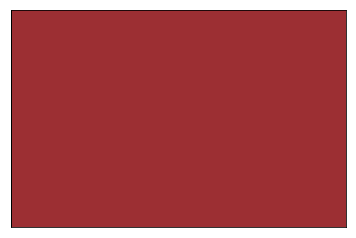

none


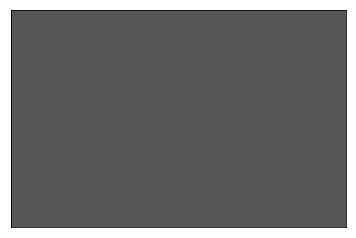

none


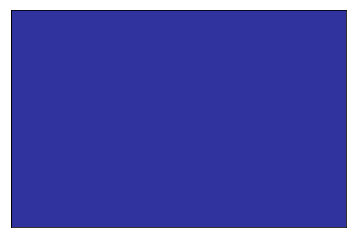

none


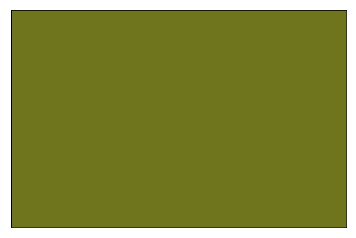

none


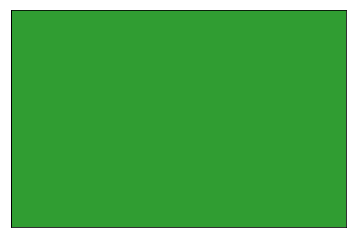

none


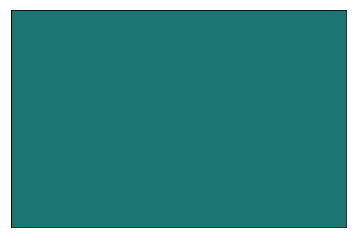

none


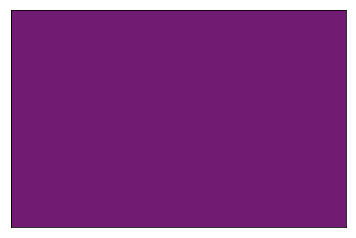

In [137]:
for center in kmeans.cluster_centers_:
    train_data.display_target(center/sum(center), "none")

In [157]:
%%time
# frozensets are hashable because they are immutable
potentially_similar = defaultdict(list)

for i, labels in enumerate(kmeans.labels_.reshape(-1, 3)):
    potentially_similar[tuple(sorted(labels))].append(i) 

CPU times: user 92.4 ms, sys: 3.8 ms, total: 96.2 ms
Wall time: 97.1 ms


In [172]:
len(potentially_similar[(0,0,0)])

355

In [525]:
# create distance matrices for potentially similar color contexts found with kmeans
color_distance_matrices = {} # map from label tuples from kmeans to 2x2 np.arrays containing pairwise color distances
for clusters in potentially_similar:
    print("Processing clusters:", clusters)
    # all_lab_colors is a list of single colors [[r, g, b], [r, g, b], ...]
    # potentially_similar's items are lists of indices of full contexts, not colors, so reshape
    # all_lab_colors to be organized by contexts to access the correct indices, and then reshape it back
    # so that cluster_colors is a list of colors just like all_lab_colors
    cluster_colors = all_lab_colors.reshape(-1, 3, 3)[potentially_similar[clusters]].reshape(-1, 3)
    
    cluster_coocur_diagonals = [] # diagonal because the vectors put here represent increasingly lower diagonals
                                 # of a matrix. On the ith diagonal, only the top i items of the ith list will 
                                 # be in the distance matrix
    
    # we can calculate color distance vector-wise, so roll one vector down by one item every iteration until all
    # pairwise distances have been calculated
    for i in range(len(cluster_colors)):
        cluster_coocur_diagonals.append(
            color.deltaE_ciede2000(cluster_colors[:len(cluster_colors) - i],
                                   np.roll(cluster_colors, -i, axis=0)[:len(cluster_colors) - i])
        )

    cluster_coocur_mat = np.zeros((len(cluster_colors), len(cluster_colors)))
    cluster_range = np.arange(len(cluster_colors))
    # this is a little ugly, we're diagonally indexing into the lower triangular component of the 
    # cluster_coocur matrix. This is equivalent to using the
    # np.diag or np.eye functions with offsets, k, going from 0 to -len(cluster_colors) but much faster
    for i in range(len(cluster_colors)):
        cluster_coocur_mat[cluster_range[i:], cluster_range[:len(cluster_colors)-i]] = cluster_coocur_diagonals[i]

    # make the matrix symmetric for giggles
    cluster_coocur_mat = cluster_coocur_mat + cluster_coocur_mat.T
    
    # add to dictionary
    color_distance_matrices[clusters] = cluster_coocur_mat

Processing clusters: (2, 2, 6)
Processing clusters: (1, 3, 4)
Processing clusters: (6, 6, 6)
Processing clusters: (1, 3, 6)
Processing clusters: (2, 3, 5)
Processing clusters: (1, 1, 3)
Processing clusters: (1, 1, 6)
Processing clusters: (0, 0, 5)
Processing clusters: (1, 4, 5)
Processing clusters: (0, 1, 5)
Processing clusters: (4, 4, 5)
Processing clusters: (1, 1, 4)
Processing clusters: (2, 2, 3)
Processing clusters: (1, 3, 5)
Processing clusters: (1, 4, 6)
Processing clusters: (0, 1, 1)
Processing clusters: (1, 1, 1)
Processing clusters: (1, 6, 6)
Processing clusters: (0, 1, 6)
Processing clusters: (0, 0, 1)
Processing clusters: (0, 3, 4)
Processing clusters: (1, 5, 6)
Processing clusters: (1, 3, 3)
Processing clusters: (1, 2, 6)
Processing clusters: (3, 4, 5)
Processing clusters: (1, 1, 5)
Processing clusters: (1, 5, 5)
Processing clusters: (0, 1, 4)
Processing clusters: (0, 1, 3)
Processing clusters: (2, 3, 4)
Processing clusters: (0, 4, 6)
Processing clusters: (0, 3, 3)
Processi

In [527]:
# create pairs of similar color contexts using previously caculated distance matrices
color_edge_list = []
all_equal_lists = []
debug_lists = []
for clusters, potential_similarities in potentially_similar.items():
    print("Processing clusters:", clusters)
    for ci in range(len(potential_similarities)):
        # color_list_1 = [all_rgb_vals[0], all_rgb_vals[0]][ci]

        for cj in range(ci + 1, len(potential_similarities)):
            #color_list_2 = [all_rgb_vals[0], all_rgb_vals[0]][cj]
            #color_list_2 = all_colors_hashable[j]
            #print('hi', i, j)

            # check if the contexts have "similar" colors
            inner_equal_list = []
            equal_list = []
            #debug_list = []
            for i in range(3):
                #color_1 = color_list_1[i]
                for j in range(3):
                    if j in inner_equal_list: continue

                    if color_distance_matrices[clusters][ci*3 + i][cj*3 + j] < 5:
                        equal_list.append((i, j, color_distance_matrices[clusters][ci*3 + i][cj*3 + j]))
                        inner_equal_list.append(j) # don't match inner color with any other
                        # debug_list.append((ci*3 + i, cj*3 + j))
                        break # don't match outer color with any other -> go to next loop iteration with i

            # print(equal_list)
            if len(equal_list) == 3: # all the colors have a match:
                color_edge_list.append((potential_similarities[ci], potential_similarities[cj]))
                all_equal_lists.append(equal_list)
                #debug_lists.append(debug_list)

Processing clusters: (2, 2, 6)
Processing clusters: (1, 3, 4)
Processing clusters: (6, 6, 6)
Processing clusters: (1, 3, 6)
Processing clusters: (2, 3, 5)
Processing clusters: (1, 1, 3)
Processing clusters: (1, 1, 6)
Processing clusters: (0, 0, 5)
Processing clusters: (1, 4, 5)
Processing clusters: (0, 1, 5)
Processing clusters: (4, 4, 5)
Processing clusters: (1, 1, 4)
Processing clusters: (2, 2, 3)
Processing clusters: (1, 3, 5)
Processing clusters: (1, 4, 6)
Processing clusters: (0, 1, 1)
Processing clusters: (1, 1, 1)
Processing clusters: (1, 6, 6)
Processing clusters: (0, 1, 6)
Processing clusters: (0, 0, 1)
Processing clusters: (0, 3, 4)
Processing clusters: (1, 5, 6)
Processing clusters: (1, 3, 3)
Processing clusters: (1, 2, 6)
Processing clusters: (3, 4, 5)
Processing clusters: (1, 1, 5)
Processing clusters: (1, 5, 5)
Processing clusters: (0, 1, 4)
Processing clusters: (0, 1, 3)
Processing clusters: (2, 3, 4)
Processing clusters: (0, 4, 6)
Processing clusters: (0, 3, 3)
Processi

In [528]:
len(color_edge_list)

86805

In [545]:
color_edge_list[2010:2020]

[(8880, 41421),
 (8880, 42967),
 (8880, 43748),
 (8880, 45600),
 (8880, 45829),
 (8880, 46546),
 (8915, 14869),
 (8915, 22015),
 (8915, 31886),
 (8915, 46425)]

In [539]:
all_equal_lists[:10]

[[(0, 0, 3.8854979162315586),
  (1, 1, 4.354020789949474),
  (2, 2, 4.340655383030973)],
 [(0, 0, 2.6853879851397453),
  (1, 1, 4.052921954760585),
  (2, 2, 3.90317848160786)],
 [(0, 0, 4.828205007755316),
  (1, 1, 4.876682519528544),
  (2, 2, 1.275356978421368)],
 [(0, 1, 2.519479975770075),
  (1, 0, 4.558083417119429),
  (2, 2, 2.3144798065253656)],
 [(0, 2, 0.7585151106335756),
  (1, 0, 2.47658817239927),
  (2, 1, 2.5644753997397642)],
 [(0, 1, 0.8204623159721629),
  (1, 2, 1.3013659176006351),
  (2, 0, 2.514383156136686)],
 [(0, 2, 3.9640321001440535),
  (1, 0, 0.645542923132143),
  (2, 1, 1.7958276641240765)],
 [(0, 1, 4.987043058079224),
  (1, 0, 4.604406281035787),
  (2, 2, 3.191850478973731)],
 [(0, 1, 3.9640321001440535),
  (1, 2, 1.2803967232171267),
  (2, 0, 3.6145814212357883)],
 [(0, 2, 2.418140070645796),
  (1, 0, 4.476911294808285),
  (2, 1, 1.3417492143663092)]]

In [561]:
# let me filter these color edges by two criteria
# - whether the targets are different
# - whether the human listener selected the target correctly in both contexts

keep_edges = np.zeros(len(color_edge_list), dytpe=np.int)
for edge_num, edge in enumerate(color_edge_list):
    ci, cj = edge
    
    # human listener chose correct color
    keep_edge = all_data[ci].outcome and all_data[cj].outcome
    
    # targets aren't the same
    for pair_i, pair_j, _ in all_equal_lists[edge_num]:
        if pair_i == 0 and pair_j == 0: # then the targets are the same
            keep_edge = False
            break
    
    keep_edges[edge_num] = keep_edge
    

In [569]:
sum(keep_edges) # should be 39399

39399

In [570]:
len(keep_edges) # should be  86805

86805

In [560]:
all_data[0].outcome # should be False

False

In [583]:
filtered_color_edge_list = np.array(color_edge_list)[keep_edges.nonzero()]

In [592]:
filtered_matchup_lists = np.array(all_equal_lists)[keep_edges.nonzero()]

In [607]:
# just for fun, let's separate into train, dev, test
# Specify each combination of data splits with a ternary number.
# Where train = 1, dev = 3, and test = 9. This makes it easy to pick
# out the conditions we want: i.e. no train? Make sure number % 3 == 0
# no dev? (number//3) % 3 == 0.
data_split = np.zeros(len(filtered_color_edge_list), dtype=np.int)

for edge_num, edge in enumerate(filtered_color_edge_list):
    for color_ind in edge:
        if color_ind < len(train_data):
            data_split[edge_num] += 1
        elif color_ind - len(train_data) < len(dev_data):
            data_split[edge_num] += 3
        else: #if edge[0] - len(train_data) - len(dev_data) < len(test_data) and edge[1] - len(train_data) < len(dev_data):
            data_split[edge_num] += 9

In [ ]:
# train train is 2
# dev dev is 6
# test test is 18

In [609]:
filtered_color_edge_list_dev = filtered_color_edge_list[data_split == 6]

In [611]:
len(filtered_color_edge_list_dev) # should be 4423

4423

In [612]:
filtered_color_edge_list_train = filtered_color_edge_list[data_split == 2]

In [613]:
len(filtered_color_edge_list_train) # should be 4063

4063

In [614]:
filtered_color_edge_list_test = filtered_color_edge_list[data_split == 18]

In [616]:
len(filtered_color_edge_list_test) # should be 4715

4715

In [617]:
# no train -- first ternary-digit is 0
filtered_color_edge_list_notrain = filtered_color_edge_list[data_split%3 == 0]

In [618]:
len(filtered_color_edge_list_notrain) # should be 18135

18135

In [598]:
filtered_color_edge_list_dev = list(filtered_color_edge_list_dev)

In [621]:
filtered_dev_conditions = [(all_data[i].condition, all_data[j].condition) for i, j in filtered_color_edge_list_dev]

In [623]:
Counter(filtered_dev_conditions)

Counter({('close', 'close'): 3885,
         ('close', 'split'): 9,
         ('far', 'far'): 262,
         ('far', 'split'): 21,
         ('split', 'close'): 11,
         ('split', 'far'): 16,
         ('split', 'split'): 219})

In [637]:
filtered_test_conditions = [(all_data[i].condition, all_data[j].condition) for i, j in filtered_color_edge_list_test]

In [638]:
Counter(filtered_test_conditions)

Counter({('close', 'close'): 4122,
         ('close', 'split'): 7,
         ('far', 'far'): 296,
         ('far', 'split'): 23,
         ('split', 'close'): 12,
         ('split', 'far'): 33,
         ('split', 'split'): 222})

In [642]:
# ok, so I realized that constructing another fake dataset is kind of stupid and wasteful and also not possible
# because I don't even have reference captions for GOOD utterances. If you just use the captions themselves, it
# doesn't work out too well. So I'm going to create triples of (actual, good proposal (same target), bad proposal (different target))
# and see if that works.

keep_edges_good = np.zeros(len(color_edge_list), dtype=np.int)
for edge_num, edge in enumerate(color_edge_list):
    ci, cj = edge
    
    keep_edge = False
    # targets ARE the same
    for pair_i, pair_j, _ in all_equal_lists[edge_num]:
        if pair_i == 0 and pair_j == 0: # then the targets are the same
            keep_edge = True
            break
            
    # human listener chose correct color
    keep_edge = keep_edge and all_data[ci].outcome and all_data[cj].outcome
    
    keep_edges_good[edge_num] = keep_edge

In [644]:
sum(keep_edges_good) # should be 21754

21754

In [647]:
filtered_color_edge_list_good = np.array(color_edge_list)[keep_edges_good.nonzero()]

In [649]:
# just for fun, let's separate into train, dev, test
# Specify each combination of data splits with a ternary number.
# Where train = 1, dev = 3, and test = 9. This makes it easy to pick
# out the conditions we want: i.e. no train? Make sure number % 3 == 0
# no dev? (number//3) % 3 == 0.
data_split_good = np.zeros(len(filtered_color_edge_list_good), dtype=np.int)

for edge_num, edge in enumerate(filtered_color_edge_list_good):
    for color_ind in edge:
        if color_ind < len(train_data):
            data_split_good[edge_num] += 1
        elif color_ind - len(train_data) < len(dev_data):
            data_split_good[edge_num] += 3
        else:
            data_split_good[edge_num] += 9

In [650]:
filtered_color_edge_list_dev_good = filtered_color_edge_list_good[data_split_good == 6]

In [651]:
len(filtered_color_edge_list_dev_good) # should be 2549

2549

In [652]:
filtered_dev_conditions_good = [(all_data[i].condition, all_data[j].condition) for i, j in filtered_color_edge_list_dev_good]

In [685]:
edge_triples = []

for bad_edge in filtered_color_edge_list_dev:
    for good_edge in filtered_color_edge_list_dev_good:
        
        if bad_edge[0] == good_edge[0]:
            edge_triples.append([bad_edge[0], bad_edge[1], good_edge[1]])

In [686]:
len(edge_triples) # should be 4623

4623

In [707]:
# finally, let's filter the edge triples to only include the ones that are officially in the same context
# also, keep in mind, edge_triples are JUST dev data
edge_triples_same_condition = []
for triple in edge_triples:
    triple_conditions = set([all_data[t].condition for t in triple])
    if len(triple_conditions) == 1: # i.e. all conditons are the same
        edge_triples_same_condition.append(triple)

In [709]:
len(edge_triples_same_condition) # should be 4614

4614

In [ ]:
# ok, so not that big of a difference

In [727]:
# https://www.nltk.org/api/nltk.translate.html#nltk.translate.bleu_score.SmoothingFunction.method4
# we use method 4 because it seems most appropriate for a mix of very short and longer captions 
#(even really BLEU 2 should be ok)
hyp = ["pink", "bright"]
ref = ["bright", "pink"]
sf = nltk.bleu_score.SmoothingFunction()
nltk.bleu_score.sentence_bleu([ref], hyp, smoothing_function=sf.method2, weights=(1, 0, 0, 0))

1.0

In [716]:
tokenizer = caption_featurizers.EndingTokenizer()

In [735]:
bleu_scores = [] # (bad, good)
for triple in edge_triples_same_condition:
    actual, bad, good = triple
    actual_utt = tokenizer.tokenize(all_data[actual].caption)
    bad_utt = tokenizer.tokenize(all_data[bad].caption)
    good_utt = tokenizer.tokenize(all_data[good].caption)
    
    bad_bleu = nltk.bleu_score.sentence_bleu([actual_utt], bad_utt, smoothing_function=sf.method1, weights=(1, 0, 0, 0))
    good_bleu = nltk.bleu_score.sentence_bleu([actual_utt], good_utt, smoothing_function=sf.method1, weights=(1, 0, 0, 0))
    
    bleu_scores.append([bad_bleu, good_bleu])

In [736]:
bleu_scores[:10]

[[0.11111111111111109, 1.0],
 [0, 1.0],
 [0, 0],
 [0.5, 0],
 [0.25, 0.3333333333333333],
 [0.25, 0.3333333333333333],
 [0.25, 0.36787944117144233],
 [0, 0.3333333333333333],
 [0, 0.3333333333333333],
 [0, 0.36787944117144233]]

In [738]:
bad_bleu_scores = np.array(bleu_scores)[:, 0]

In [739]:
good_bleu_scores = np.array(bleu_scores)[:, 1]

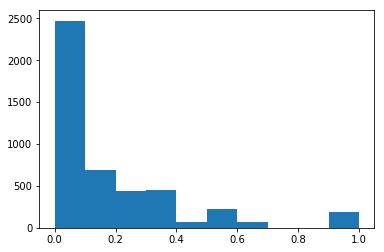

In [745]:
plt.hist(good_bleu_scores)
plt.show()

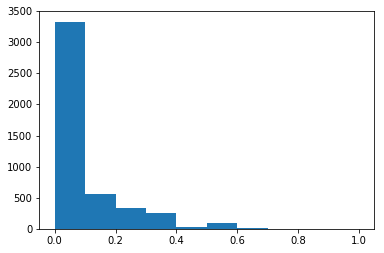

In [746]:
plt.hist(bad_bleu_scores)
plt.show()

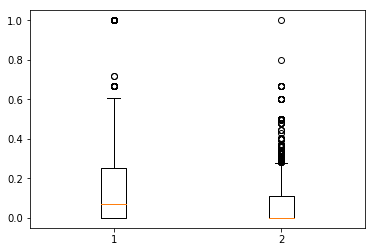

In [753]:
plt.boxplot([good_bleu_scores, bad_bleu_scores])
plt.show()

In [ ]:
# ok, so now let's see how this compares to literal listener predictions. I think the best way of doing this is to 
# run over the good and bad utterances / contexts and make boxplots with their probability mass:

In [58]:
# first, necesessary imports:
import color_featurizers
from models import LiteralListener, CaptionEncoder
from experiment import FeatureHandler

In [59]:
caption_phi = caption_featurizers.CaptionFeaturizer(tokenizer=caption_featurizers.EndingTokenizer)
color_phi = color_featurizers.ColorFeaturizer(color_featurizers.color_phi_fourier, "rgb", normalized=True) # NOTE: RGB

feature_handler_dev = FeatureHandler(train_data, dev_data, caption_phi, color_phi, randomized_colors=True)

In [60]:
X_assess_dev = feature_handler_dev.test_features()
y_assess_dev = feature_handler_dev.test_targets()

In [937]:
model = LiteralListener(CaptionEncoder)
model.init_model(
            embed_dim=100,
            hidden_dim=100,
            vocab_size=feature_handler.caption_featurizer.caption_indexer.size,
            color_dim=54)

In [938]:
model.load_model("../model/literal_listener_5epoch_endings_tkn.params")

In [944]:
lit_listener_predictions_dev = model.predict(X_assess_dev)

In [764]:
y_assess[:10]

array([2, 2, 1, 2, 0, 0, 1, 2, 2, 2])

In [945]:
lit_listener_probs_dev = np.argmax(lit_listener_predictions_dev, axis=1)

In [946]:
sum(lit_listener_probs_dev == y_assess_dev) / len(lit_listener_probs_dev) # hmmm... that accuracy isn't great. I thought I got better. Probably should try retraining


0.7437779195915762

In [768]:
lit_listener_probs = np.exp(lit_listener_probs)

In [769]:
lit_listener_probs[:10]

array([0.09662738, 0.62725145, 0.95980865, 0.20579526, 0.01225206,
       0.6822608 , 0.51138556, 0.25904444, 0.08385883, 0.19791703],
      dtype=float32)

In [771]:
good_lit_listener_scores = []
bad_lit_listener_scores = []

for triple in edge_triples_same_condition:
    actual, bad, good = triple
    
    # because these are taken from all_data, we need to put the indices back to 
    # the dev_data domain.
    good -= len(train_data)
    bad -= len(train_data)
    good_lit_listener_scores.append(lit_listener_probs[good])
    bad_lit_listener_scores.append(lit_listener_probs[bad])

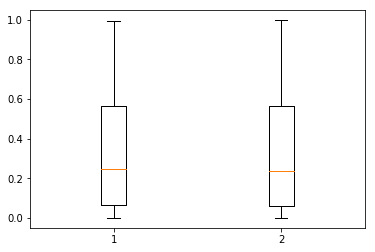

In [773]:
plt.boxplot([good_lit_listener_scores, bad_lit_listener_scores])
plt.show()

Drat that didn't work. I need to actually evaluate the bad caption :( so this isn't going to be quite so straightforward. I think the easiest thing to do would be to just create a new "dataset" that has the colors of the actual, the caption of the good and the colors of the actual and the caption of the bad

In [61]:
ngram_comparison_dataset = []

for triple in edge_triples_same_condition:
    actual, bad, good = triple # indices into all_data
    good_ex = copy.deepcopy(all_data[actual])
    bad_ex = copy.deepcopy(all_data[actual])
    
    good_ex.caption = all_data[good].caption
    bad_ex.caption = all_data[bad].caption
    
    ngram_comparison_dataset.append(good_ex)
    ngram_comparison_dataset.append(bad_ex)
    


In [62]:
len(ngram_comparison_dataset)

9228

In [63]:
feature_handler_ngram = FeatureHandler(train_data, ngram_comparison_dataset, caption_phi, color_phi, randomized_colors=True)

In [64]:
X_assess = feature_handler_ngram.test_features()
y_assess = feature_handler_ngram.test_targets()

In [65]:
model = LiteralListener(CaptionEncoder)
model.init_model(
            embed_dim=100,
            hidden_dim=100,
            vocab_size=feature_handler_ngram.caption_featurizer.caption_indexer.size, # depends only on train data
            color_dim=54)

In [66]:
model.load_model("../model/literal_listener_5epoch_endings_tkn.params")

In [67]:
lit_listener_predictions = model.predict(X_assess)

In [68]:
lit_listener_predictions[:10]

array([[-3.7659645e-02, -3.3873644e+00, -5.7566028e+00],
       [-1.7762370e+00, -1.2452747e+01, -1.8545961e-01],
       [-3.3873644e+00, -5.7566028e+00, -3.7659645e-02],
       [-1.1658192e-02, -4.5763745e+00, -6.6464639e+00],
       [-6.3906956e+00, -7.9474773e+00, -2.0322800e-03],
       [-2.0792765e+01, -2.0519293e+01,  0.0000000e+00],
       [-7.9474773e+00, -6.3906956e+00, -2.0322800e-03],
       [-1.3593566e+01, -1.3300896e-02, -4.3266611e+00],
       [-3.7659557e+01, -1.5043261e+01,  0.0000000e+00],
       [-4.0802984e+00, -2.5327468e-01, -1.5757954e+00]], dtype=float32)

In [69]:
lit_listener_probs = np.exp(lit_listener_predictions[np.arange(len(lit_listener_predictions)), y_assess])

In [70]:
good_lit_listener_scores = lit_listener_probs[np.arange(0, len(lit_listener_probs), 2)]

In [71]:
bad_lit_listener_scores = lit_listener_probs[np.arange(1, len(lit_listener_probs), 2)]

In [72]:
len(bad_lit_listener_scores)

4614

In [73]:
len(good_lit_listener_scores)

4614

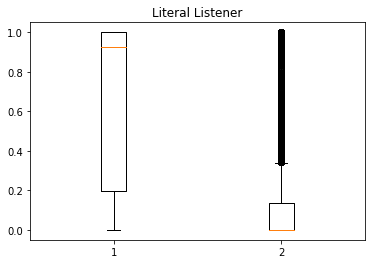

Good \mu: 0.654 stdev: 0.405	 Bad \mu: 0.162 stdev: 0.306


In [81]:
plt.boxplot([good_lit_listener_scores, bad_lit_listener_scores])
plt.title("Literal Listener")
#plt.(["Good", "Bad"])
plt.show()


print("Good \mu: {:.3f} stdev: {:.3f}\t Bad \mu: {:.3f} stdev: {:.3f}".format(np.mean(good_lit_listener_scores),
                                                              np.std(good_lit_listener_scores),
                                                              np.mean(bad_lit_listener_scores),
                                                              np.std(bad_lit_listener_scores)))

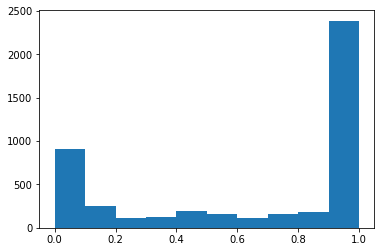

In [956]:
plt.hist(good_lit_listener_scores)
plt.show()

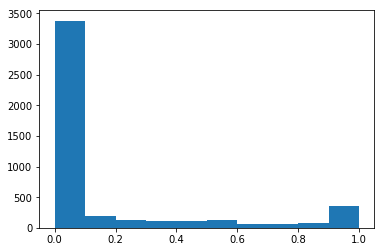

In [957]:
plt.hist(bad_lit_listener_scores)
plt.show()

In [958]:
# ok, so this doesn't work. Let's split up by condition and see what happens
conditions = []

for triple in edge_triples_same_condition:
    actual, _, _ = triple # they are all the same condition
    conditions.append(all_data[actual].condition)
    #conditions.append(all_data[actual].condition)

In [959]:
len(conditions)

4614

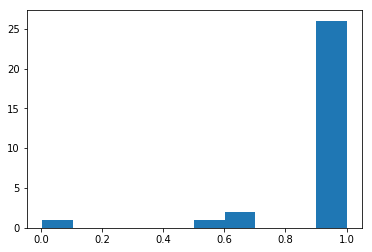

In [960]:
plt.hist(good_lit_listener_scores[np.array(conditions) == "far"])
plt.show()

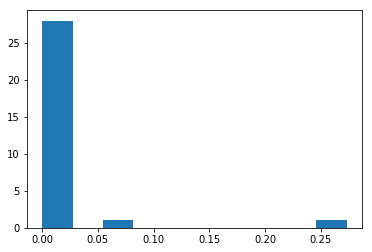

In [961]:
plt.hist(bad_lit_listener_scores[np.array(conditions) == "far"])
plt.show()

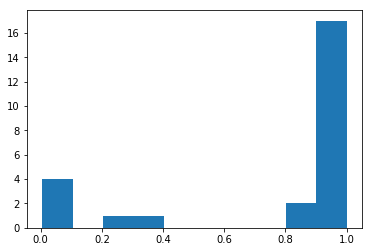

In [962]:
plt.hist(good_lit_listener_scores[np.array(conditions) == "split"])
plt.show()

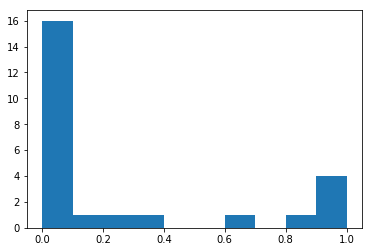

In [963]:
plt.hist(bad_lit_listener_scores[np.array(conditions) == "split"])
plt.show()

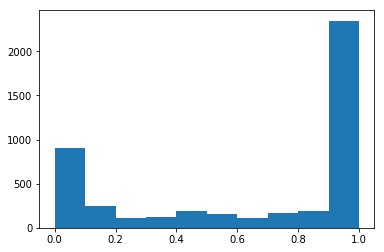

In [964]:
plt.hist(good_lit_listener_scores[np.array(conditions) == "close"])
plt.show()

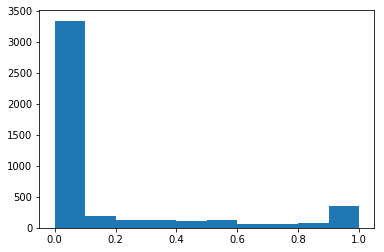

In [965]:
plt.hist(bad_lit_listener_scores[np.array(conditions) == "close"])
plt.show()

In [966]:
# let's try with other metrics:
# https://github.com/Diego999/py-rouge/tree/master/rouge
# ROUGE next:
# https://www.aclweb.org/anthology/W04-1013
import rouge

In [1010]:
evaluator = rouge.Rouge(['rouge-n', 'rouge-l', 'rouge-w'], max_n = 2, apply_avg=False)

In [9]:
good_hypotheses = []
bad_hypotheses = []
references = []

for triple in edge_triples_same_condition:
    actual, bad, good = triple
    good_hypotheses.append(all_data[good].caption)
    bad_hypotheses.append(all_data[bad].caption)
    references.append([all_data[actual].caption])


In [1011]:
good_rouge_scores = evaluator.get_scores(good_hypotheses, references)

In [1012]:
bad_rouge_scores = evaluator.get_scores(bad_hypotheses, references)

In [1013]:
good_rouge_scores

{'rouge-1': [{'f': [1.0], 'p': [1.0], 'r': [1.0]},
  {'f': [1.0], 'p': [1.0], 'r': [1.0]},
  {'f': [0.0], 'p': [0.0], 'r': [0.0]},
  {'f': [0.0], 'p': [0.0], 'r': [0.0]},
  {'f': [0.5], 'p': [0.5], 'r': [0.5]},
  {'f': [0.5], 'p': [0.5], 'r': [0.5]},
  {'f': [0.6666666666666666], 'p': [1.0], 'r': [0.5]},
  {'f': [0.5], 'p': [0.5], 'r': [0.5]},
  {'f': [0.5], 'p': [0.5], 'r': [0.5]},
  {'f': [0.6666666666666666], 'p': [1.0], 'r': [0.5]},
  {'f': [0.5], 'p': [0.5], 'r': [0.5]},
  {'f': [0.5], 'p': [0.5], 'r': [0.5]},
  {'f': [0.6666666666666666], 'p': [1.0], 'r': [0.5]},
  {'f': [0.0], 'p': [0.0], 'r': [0.0]},
  {'f': [0.0], 'p': [0.0], 'r': [0.0]},
  {'f': [0.0], 'p': [0.0], 'r': [0.0]},
  {'f': [0.0], 'p': [0.0], 'r': [0.0]},
  {'f': [0.22222222222222224], 'p': [0.5], 'r': [0.14285714285714285]},
  {'f': [0.22222222222222224], 'p': [0.5], 'r': [0.14285714285714285]},
  {'f': [0.22222222222222224], 'p': [0.5], 'r': [0.14285714285714285]},
  {'f': [0.22222222222222224], 'p': [0.5], 'r': 

In [999]:
good_rouge_scores_f = [score["f"] for score in good_rouge_scores['rouge-1']]
bad_rouge_scores_f = [score["f"] for score in bad_rouge_scores['rouge-1']]

In [1003]:
good_rouge_scores_f = np.array(good_rouge_scores_f).flatten()
bad_rouge_scores_f = np.array(bad_rouge_scores_f).flatten()

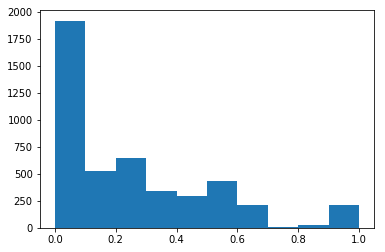

In [1007]:
plt.hist(good_rouge_scores_f)
plt.show()

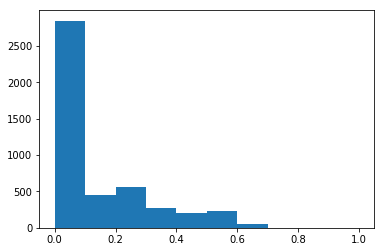

In [1008]:
plt.hist(bad_rouge_scores_f)
plt.show()

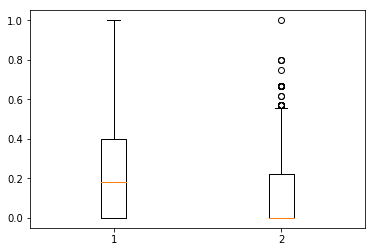

In [1009]:
plt.boxplot([good_rouge_scores_f, bad_rouge_scores_f])
plt.show()

In [1017]:
good_rouge_l_scores_f = np.array([score["f"] for score in good_rouge_scores['rouge-l']]).flatten() # ROUGE-L
bad_rouge_l_scores_f = np.array([score["f"] for score in bad_rouge_scores['rouge-l']]).flatten()

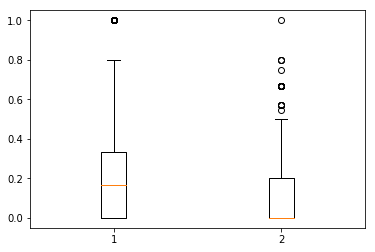

In [1018]:
plt.boxplot([good_rouge_l_scores_f, bad_rouge_l_scores_f])
plt.show()

In [1019]:
good_rouge_w_scores_f = np.array([score["f"] for score in good_rouge_scores['rouge-w']]).flatten() # ROUGE-W
bad_rouge_w_scores_f = np.array([score["f"] for score in bad_rouge_scores['rouge-w']]).flatten()

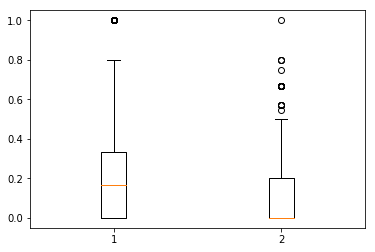

In [1020]:
plt.boxplot([good_rouge_w_scores_f, bad_rouge_w_scores_f])
plt.show()

In [1021]:
good_rouge_2_scores_f = np.array([score["f"] for score in good_rouge_scores['rouge-2']]).flatten() # ROUGE-2
bad_rouge_2_scores_f = np.array([score["f"] for score in bad_rouge_scores['rouge-2']]).flatten()

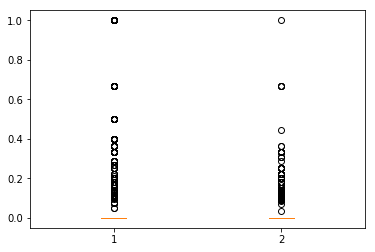

In [1022]:
plt.boxplot([good_rouge_2_scores_f, bad_rouge_2_scores_f]) # all of them are 0's pretty much because all of these are short.
plt.show()

In [976]:
good_hypotheses[:10]

['blue',
 'blue',
 'sky',
 'sky',
 'pinkish purple',
 'lavender purple',
 'purple',
 'pinkish purple',
 'lavender purple',
 'purple']

In [977]:
references[:10]

[['blue'],
 ['blue'],
 ['blue'],
 ['blue'],
 ['purple purple'],
 ['purple purple'],
 ['purple purple'],
 ['purple purple'],
 ['purple purple'],
 ['purple purple']]

In [1033]:
with open("../data/dev_evaluation_indices.pkl", "wb") as pfile:
    pickle.dump(edge_triples_same_condition, pfile)

In [7]:
with open("../data/dev_evaluation_indices.pkl", "rb") as pfile:
    edge_triples_same_condition = pickle.load(pfile)

In [24]:
# https://github.com/Maluuba/nlg-eval
# calculate ALL the metrics at once

from nlgeval import NLGEval
nlgeval = NLGEval()  # loads the models


In [49]:
nlgeval.compute_individual_metrics([references[0][0], references[1][0], references[2][0]], good_hypotheses[0])

{'Bleu_1': 0.999999998000002,
 'Bleu_2': 0.0009999999985000015,
 'Bleu_3': 9.999999986666685e-05,
 'Bleu_4': 3.162277656215536e-05,
 'METEOR': 1.0,
 'ROUGE_L': 1.0,
 'CIDEr': 0.0,
 'SkipThoughtCS': 1.0000007,
 'EmbeddingAverageCosineSimilairty': 1.0,
 'VectorExtremaCosineSimilarity': 1.0,
 'GreedyMatchingScore': 1.0}

In [50]:
[references[0][0], references[1][0], references[2][0]]

['blue', 'blue', 'blue']

In [51]:
good_hypotheses[0]

'blue'

In [37]:
%%time
all_good_metrics = []
for i in range(len(references)):
    all_good_metrics.append(nlgeval.compute_individual_metrics(references[i], good_hypotheses[i]))

CPU times: user 1h 10min 30s, sys: 2min 23s, total: 1h 12min 54s
Wall time: 54min 44s


In [34]:
%%time
all_bad_metrics = []
starttime = time.time()
for i in range(len(references)):
    if i % 40 == 0:
        print("Time: {:2f}\tIteration {}".format(time.time() - starttime, i))
    all_bad_metrics.append(nlgeval.compute_individual_metrics(references[i], bad_hypotheses[i]))

Time: 4.0531158447265625e-06	Iteration 0
Time: 27.41585683822632	Iteration 40
Time: 54.62174201011658	Iteration 80
Time: 85.32118391990662	Iteration 120
Time: 119.32896423339844	Iteration 160
Time: 148.31500101089478	Iteration 200
Time: 177.386488199234	Iteration 240
Time: 204.8525378704071	Iteration 280
Time: 232.27207207679749	Iteration 320
Time: 260.4955132007599	Iteration 360
Time: 290.1267330646515	Iteration 400
Time: 318.43083810806274	Iteration 440
Time: 344.0724070072174	Iteration 480
Time: 371.5880150794983	Iteration 520
Time: 398.0049469470978	Iteration 560
Time: 426.26746702194214	Iteration 600
Time: 455.4890170097351	Iteration 640
Time: 483.4458818435669	Iteration 680
Time: 510.66291308403015	Iteration 720
Time: 538.7618980407715	Iteration 760
Time: 565.8945112228394	Iteration 800
Time: 594.7378199100494	Iteration 840
Time: 627.6079339981079	Iteration 880
Time: 656.8001101016998	Iteration 920
Time: 688.6328229904175	Iteration 960
Time: 717.2418630123138	Iteration 1000
Time:

In [35]:
all_bad_metrics[:4]

[{'Bleu_1': 0.12499999998437514,
  'Bleu_2': 4.225771273076634e-09,
  'Bleu_3': 1.4384239564536296e-11,
  'Bleu_4': 8.783602618320613e-13,
  'METEOR': 0.20512820512820512,
  'ROUGE_L': 0.2584745762711865,
  'CIDEr': 0.0,
  'SkipThoughtCS': 0.5108539,
  'EmbeddingAverageCosineSimilairty': 0.730718,
  'VectorExtremaCosineSimilarity': 0.537336,
  'GreedyMatchingScore': 0.708289},
 {'Bleu_1': 2.499999999375e-16,
  'Bleu_2': 2.8867513451061596e-16,
  'Bleu_3': 3.4668063705012784e-16,
  'Bleu_4': 4.518010015696094e-16,
  'METEOR': 0.23703703703703707,
  'ROUGE_L': 0.0,
  'CIDEr': 0.0,
  'SkipThoughtCS': 0.24021506,
  'EmbeddingAverageCosineSimilairty': 0.604512,
  'VectorExtremaCosineSimilarity': 0.469743,
  'GreedyMatchingScore': 0.49259},
 {'Bleu_1': 1.2499999998437502e-16,
  'Bleu_2': 1.3363062093831524e-16,
  'Bleu_3': 1.43842395645363e-16,
  'Bleu_4': 1.5619699682123511e-16,
  'METEOR': 0.0,
  'ROUGE_L': 0.0,
  'CIDEr': 0.0,
  'SkipThoughtCS': 0.3022064,
  'EmbeddingAverageCosineSimilai

In [39]:
# with open("../data/bad_metrics_dict.pkl", "wb") as pfile:
#     pickle.dump(all_bad_metrics, pfile)

In [40]:
# with open("../data/good_metrics_dict.pkl", "wb") as pfile:
#     pickle.dump(all_good_metrics, pfile)

In [41]:
all_good_metrics[0]

{'Bleu_1': 0.999999998000002,
 'Bleu_2': 0.0009999999985000015,
 'Bleu_3': 9.999999986666685e-05,
 'Bleu_4': 3.162277656215536e-05,
 'METEOR': 1.0,
 'ROUGE_L': 1.0,
 'CIDEr': 0.0,
 'SkipThoughtCS': 1.0000007,
 'EmbeddingAverageCosineSimilairty': 1.0,
 'VectorExtremaCosineSimilarity': 1.0,
 'GreedyMatchingScore': 1.0}

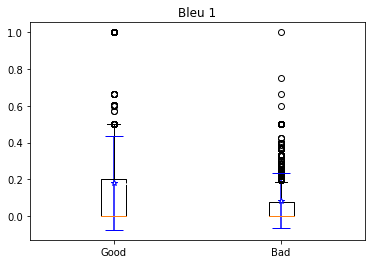

Good \mu: 0.145 stdev: 0.238	 Bad \mu: 0.062 stdev: 0.123


In [128]:
all_good_bleu_1 = [metric['Bleu_1'] for metric in all_good_metrics]
all_bad_bleu_1 = [metric['Bleu_1'] for metric in all_bad_metrics]

bp = plt.boxplot([all_good_bleu_1, all_bad_bleu_1])
plt.title("Bleu 1")

plt.xticks([1, 2], ["Good", "Bad"])
med = bp['medians']
means_xs = np.mean([m.get_xdata() for m in med], axis=1)
means = [np.mean(all_good_rouge_l), np.mean(all_bad_rouge_l)]
stds = [np.std(all_good_rouge_l), np.std(all_bad_rouge_l)]

plt.errorbar(means_xs, means, color='w', marker='*',
             markeredgecolor='b', ecolor='b', yerr=stds,
             capsize=9)



plt.show()

print("Good \mu: {:.3f} stdev: {:.3f}\t Bad \mu: {:.3f} stdev: {:.3f}".format(np.mean(all_good_bleu_1),
                                                              np.std(all_good_bleu_1),
                                                              np.mean(all_bad_bleu_1),
                                                              np.std(all_bad_bleu_1)))

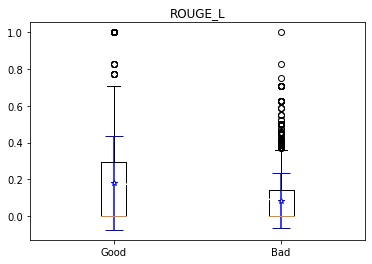

Good \mu: 0.182 stdev: 0.256	 Bad \mu: 0.085 stdev: 0.148


In [127]:
all_good_rouge_l = [metric['ROUGE_L'] for metric in all_good_metrics]
all_bad_rouge_l = [metric['ROUGE_L'] for metric in all_bad_metrics]

bp = plt.boxplot([all_good_rouge_l, all_bad_rouge_l])
plt.title("ROUGE_L")

plt.xticks([1, 2], ["Good", "Bad"])
med = bp['medians']
means_xs = np.mean([m.get_xdata() for m in med], axis=1)
means = [np.mean(all_good_rouge_l), np.mean(all_bad_rouge_l)]
stds = [np.std(all_good_rouge_l), np.std(all_bad_rouge_l)]

plt.errorbar(means_xs, means, color='w', marker='*',
             markeredgecolor='b', ecolor='b', yerr=stds,
             capsize=9)

plt.show()
print("Good \mu: {:.3f} stdev: {:.3f}\t Bad \mu: {:.3f} stdev: {:.3f}".format(np.mean(all_good_rouge_l),
                                                              np.std(all_good_rouge_l),
                                                              np.mean(all_bad_rouge_l),
                                                              np.std(all_bad_rouge_l)))

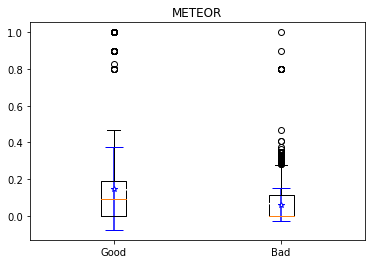

Good \mu: 0.149 stdev: 0.225	 Bad \mu: 0.060 stdev: 0.089


In [126]:
# meteor does a little better
all_good_meteor = [metric['METEOR'] for metric in all_good_metrics]
all_bad_meteor = [metric['METEOR'] for metric in all_bad_metrics]

bp = plt.boxplot([all_good_meteor, all_bad_meteor])
plt.title("METEOR")

plt.xticks([1, 2], ["Good", "Bad"])
med = bp['medians']
means_xs = np.mean([m.get_xdata() for m in med], axis=1)
means = [np.mean(all_good_meteor), np.mean(all_bad_meteor)]
stds = [np.std(all_good_meteor), np.std(all_bad_meteor)]

plt.errorbar(means_xs, means, color='w', marker='*',
             markeredgecolor='b', ecolor='b', yerr=stds,
             capsize=9)

plt.show()
print("Good \mu: {:.3f} stdev: {:.3f}\t Bad \mu: {:.3f} stdev: {:.3f}".format(np.mean(all_good_meteor),
                                                              np.std(all_good_meteor),
                                                              np.mean(all_bad_meteor),
                                                              np.std(all_bad_meteor)))

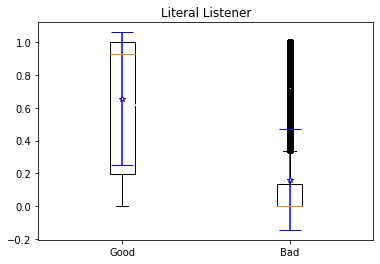

Good \mu: 0.654 stdev: 0.405	 Bad \mu: 0.162 stdev: 0.306


In [125]:
# Compared to our literal listener:
# https://matplotlib.org/examples/pylab_examples/boxplot_demo2.html

bp = plt.boxplot([good_lit_listener_scores, bad_lit_listener_scores])
plt.title("Literal Listener")
plt.xticks([1, 2], ["Good", "Bad"])

med = bp['medians']
means_xs = np.mean([m.get_xdata() for m in med], axis=1)
means = [np.mean(good_lit_listener_scores), np.mean(bad_lit_listener_scores)]
stds = [np.std(good_lit_listener_scores), np.std(bad_lit_listener_scores)]

plt.errorbar(means_xs, means, color='w', marker='*',
             markeredgecolor='b', ecolor='b', yerr=stds,
             capsize=9)
plt.show()

print("Good \mu: {:.3f} stdev: {:.3f}\t Bad \mu: {:.3f} stdev: {:.3f}".format(np.mean(good_lit_listener_scores),
                                                              np.std(good_lit_listener_scores),
                                                              np.mean(bad_lit_listener_scores),
                                                              np.std(bad_lit_listener_scores)))

In [93]:
np.mean([m.get_xdata() for m in med], axis=1)

array([1., 2.])

In [98]:
xs = np.mean([m.get_xdata() for m in med], axis=1)

In [99]:
xs

array([1., 2.])

<ErrorbarContainer object of 3 artists>

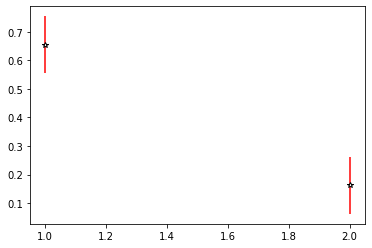

In [115]:
plt.errorbar(np.mean([m.get_xdata() for m in med], axis=1), [np.mean(good_lit_listener_scores), np.mean(bad_lit_listener_scores)],
             color='w', marker='*', markeredgecolor='k', yerr=[0.1, 0.1], ecolor="r")

In [57]:
# I want to see how CIDEr does because it's meant for image captioning, but it looks like it's kind of going to be 
# a pain to do right now. I'll have to put in on the list of things to do, but for now what we have now looks pretty
# promising

In [130]:
# I'm also just going to try and train a better listener using the hyper parameters we found a few weeks ago:

model_improved = LiteralListener(CaptionEncoder, num_epochs=5, lr=0.0005)
model_improved.init_model(
            embed_dim=100,
            hidden_dim=100,
            vocab_size=feature_handler_ngram.caption_featurizer.caption_indexer.size,
            color_dim=54)


In [131]:
X_train = feature_handler_ngram.train_features()
y_train = feature_handler_ngram.train_targets()

In [132]:
model_improved.fit(X_train, y_train)

---EPOCH 0---
0m 0s (0:0 0.00%) 0.0002
0m 10s (0:1000 7.90%) 1.4661
0m 21s (0:2000 15.79%) 1.4264
0m 33s (0:3000 23.69%) 1.3142
0m 44s (0:4000 31.58%) 1.1910
0m 55s (0:5000 39.48%) 1.2800
1m 6s (0:6000 47.37%) 1.1065
1m 16s (0:7000 55.27%) 1.0560
1m 27s (0:8000 63.17%) 1.0731
1m 37s (0:9000 71.06%) 1.0411
1m 48s (0:10000 78.96%) 0.9657
1m 58s (0:11000 86.85%) 0.9156
2m 8s (0:12000 94.75%) 0.8917
AFTER EPOCH 0 - AVERAGE VALIDATION LOSS: 0.9079852784474691
---EPOCH 1---
2m 20s (1:0 0.00%) 0.0007
2m 30s (1:1000 7.90%) 0.8295
2m 42s (1:2000 15.79%) 0.9310
2m 53s (1:3000 23.69%) 0.9531
3m 5s (1:4000 31.58%) 0.8936
3m 15s (1:5000 39.48%) 1.0280
3m 28s (1:6000 47.37%) 0.8071
3m 40s (1:7000 55.27%) 0.7743
3m 51s (1:8000 63.17%) 0.8372
4m 1s (1:9000 71.06%) 0.7842
4m 13s (1:10000 78.96%) 0.7633
4m 23s (1:11000 86.85%) 0.7196
4m 33s (1:12000 94.75%) 0.7152
AFTER EPOCH 1 - AVERAGE VALIDATION LOSS: 0.779062245051066
---EPOCH 2---
4m 45s (2:0 0.00%) 0.0010
4m 55s (2:1000 7.90%) 0.6924
5m 7s (2:2000

37m 50s (15:10000 78.96%) 0.4706
38m 1s (15:11000 86.85%) 0.4256
38m 11s (15:12000 94.75%) 0.4725
AFTER EPOCH 15 - AVERAGE VALIDATION LOSS: 0.6017169675827027
---EPOCH 16---
38m 23s (16:0 0.00%) 0.0008
38m 34s (16:1000 7.90%) 0.4648
38m 46s (16:2000 15.79%) 0.5904
38m 58s (16:3000 23.69%) 0.6637
39m 10s (16:4000 31.58%) 0.6436
39m 22s (16:5000 39.48%) 0.7349
39m 34s (16:6000 47.37%) 0.5029
39m 45s (16:7000 55.27%) 0.4717
39m 56s (16:8000 63.17%) 0.5612
40m 7s (16:9000 71.06%) 0.4805
40m 18s (16:10000 78.96%) 0.4644
40m 28s (16:11000 86.85%) 0.4199
40m 38s (16:12000 94.75%) 0.4681
AFTER EPOCH 16 - AVERAGE VALIDATION LOSS: 0.5996854003270468
---EPOCH 17---
40m 50s (17:0 0.00%) 0.0008
41m 1s (17:1000 7.90%) 0.4596
41m 13s (17:2000 15.79%) 0.5858
41m 26s (17:3000 23.69%) 0.6601
41m 38s (17:4000 31.58%) 0.6400
41m 49s (17:5000 39.48%) 0.7289
42m 1s (17:6000 47.37%) 0.4983
42m 11s (17:7000 55.27%) 0.4671
42m 22s (17:8000 63.17%) 0.5571
42m 33s (17:9000 71.06%) 0.4757
42m 44s (17:10000 78.96%

In [133]:
model_improved_preds = model_improved.predict(X_assess_dev)

In [134]:
model_improved_idxs = np.argmax(model_improved_preds, axis=1)

In [136]:
sum(model_improved_idxs == y_assess_dev)/len(y_assess_dev) # ehhhh. not really that much improvement

0.7543714103382259